<a href="https://colab.research.google.com/github/mlartorg/visualML/blob/master/segment_neural_synth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code by Gene Kogan from https://github.com/ml4a/ml4a-guides/blob/master/notebooks/neural-synth.ipynb
I did put out everything except feature visualization with masks, to make a separate tool for that task.

In [1]:
!pip install -U scipy==1.0.0

Requirement already up-to-date: scipy==1.0.0 in /usr/local/lib/python3.6/dist-packages (1.0.0)


In [2]:
#Grab inception model from online and unzip it (you can skip this step if you've already downloaded the model.
!wget -P . https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
!unzip inception5h.zip -d inception5h/
!rm inception5h.zip

--2020-03-11 20:51:08--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘./inception5h.zip.1’

inception5h.zip.1   100%[===================>]  47.62M  92.6MB/s    in 0.5s    

2020-03-11 20:51:09 (92.6 MB/s) - ‘./inception5h.zip.1’ saved [49937555/49937555]

Archive:  inception5h.zip
replace inception5h/imagenet_comp_graph_label_strings.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: inception5h/imagenet_comp_graph_label_strings.txt  
  inflating: inception5h/tensorflow_inception_graph.pb  
  inflating: inception5h/LICENSE     


In [3]:
# get some functions from ml4a repository
!wget https://raw.githubusercontent.com/ml4a/ml4a-guides/master/notebooks/lapnorm.py

--2020-03-11 20:51:18--  https://raw.githubusercontent.com/ml4a/ml4a-guides/master/notebooks/lapnorm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4608 (4.5K) [text/plain]
Saving to: ‘lapnorm.py.1’

lapnorm.py.1        100%[===================>]   4.50K  --.-KB/s    in 0s      

2020-03-11 20:51:18 (90.4 MB/s) - ‘lapnorm.py.1’ saved [4608/4608]



In [4]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf

# import everything from lapnorm.py
from lapnorm import *


Instructions for updating:
Use tf.gfile.GFile.


Number of layers 59
Total number of feature channels: 7548



In [0]:
def lapnorm_multi(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=True):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    if clear:
        clear_output()
    return img

One can think up many clever ways to make masks. Maybe they are arranged as overlapping concentric circles, or along diagonal lines, or even using [Perlin noise](https://github.com/caseman/noise) to get smooth organic-looking variation. 

Here is one example making a circular mask.

Now we show how to use an existing image as a set of masks, using k-means clustering to segment it into several sections which become masks.

sometimes it helps to remove background in some other tool before using k-means for segmentation.
(if you know a better way, please tell me!)
Last time I used this https://online.inpixio.com/tools/remove-background

Lowell_Mars_channels.jpg


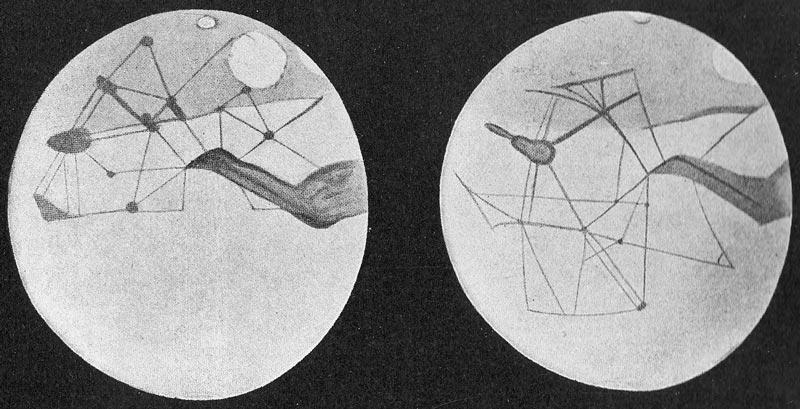

In [9]:
import re
import os

import sklearn.cluster

k = 2

for fn in os.listdir():
  if re.match('.*jpg', fn):
    print(fn)
    break


w, h = PIL.Image.open(fn).size
img0 = load_image(fn, h, w)


imgp = np.array(list(img0)).reshape((h*w, 3))
clusters, assign, _ = sklearn.cluster.k_means(imgp, k, random_state=0) # , k, init='random', n_init=1)
assign = assign.reshape((h, w))

display_image(img0)

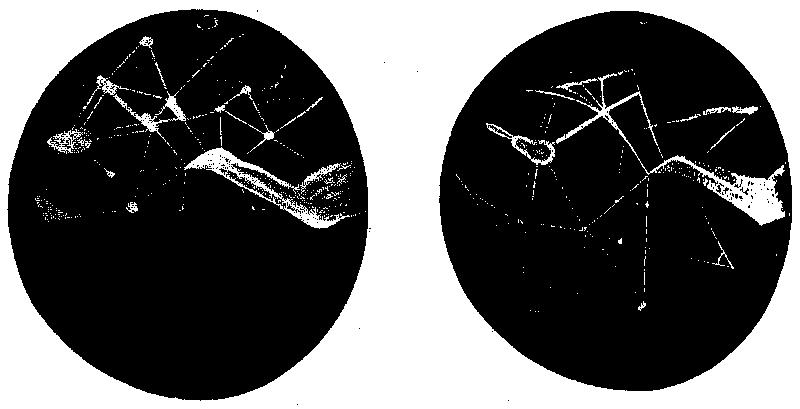

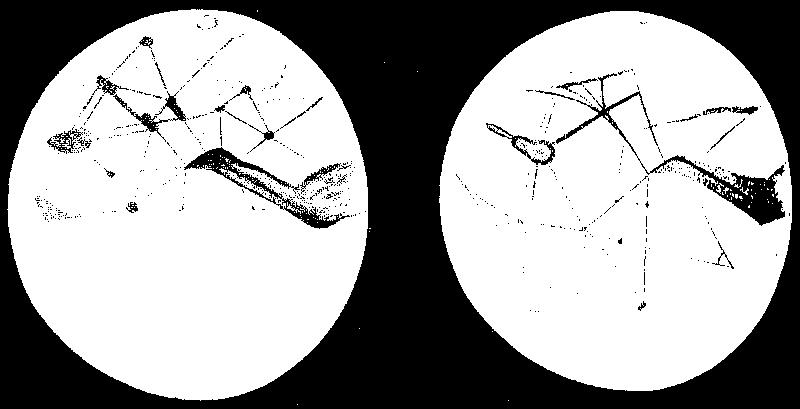

In [10]:
mask = np.zeros((h, w, k))
for i in range(k):
    mask[:,:,i] = np.multiply(np.ones((h, w)), (assign==i))

for i in range(k):
    display_image(mask[:,:,i]*255.)

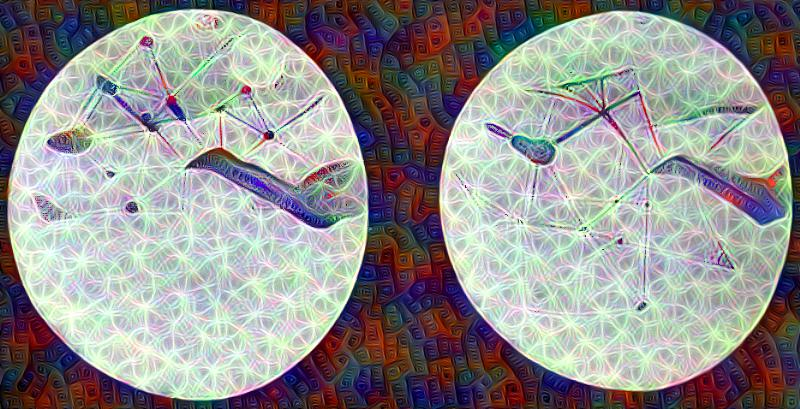

In [11]:
img0 = np.random.uniform(size=(h, w, 3)) + 100.

img0 = load_image(fn, h, w)

octave_n = 2
octave_scale = 1.2
objectives = [T('mixed3a')[:,:,:,:], 
              T('mixed3a')[:,:,:,230]]  # can dream on whole layer, channel


img1 = lapnorm_multi(objectives, img0, mask, iter_n=42, step=1.0, oct_n=octave_n, oct_s=octave_scale, lap_n=4)
display_image(img1)

